In [1]:
import duckdb

con = duckdb.connect()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

In [4]:
distritos = pd.read_excel(r"D:\Python for Data Analysis\mapas\ibge\DTB - Divisão Territorial Brasileira\RELATORIO_DTB_BRASIL_2024_DISTRITOS.xls",
                          skiprows=6)

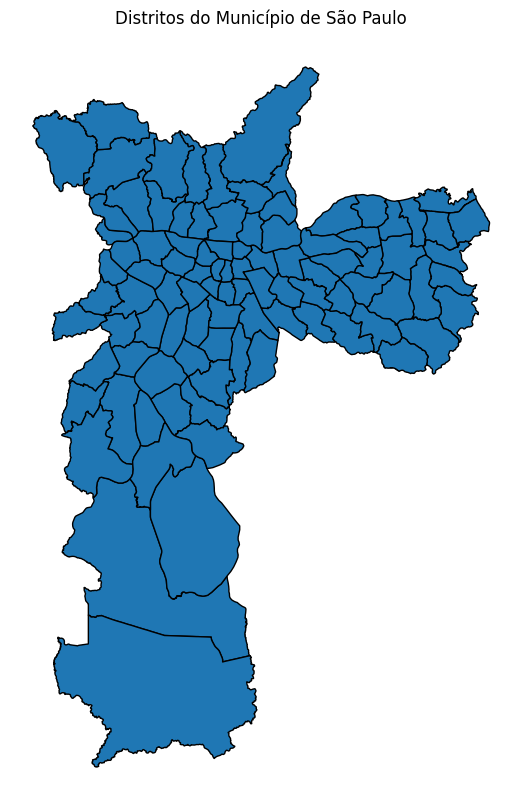

                           id  cd_identificador_distrito  \
0  distrito_municipal.8583465                    8583465   
1  distrito_municipal.8583484                    8583484   
2  distrito_municipal.8583488                    8583488   
3  distrito_municipal.8583453                    8583453   
4  distrito_municipal.8583416                    8583416   

   cd_identificador_subprefeitura cd_distrito_municipal nm_distrito_municipal  \
0                              31                    25     CIDADE TIRADENTES   
1                              18                    46       JARDIM SAO LUIS   
2                               9                    49             LIBERDADE   
3                               4                    13          CACHOEIRINHA   
4                              29                    72             SAO LUCAS   

  sg_distrito_municipal tx_escala sg_fonte_original dt_criacao  \
0                   CTI    1:5000            GEOGSG 2004-01-01   
1                   

In [6]:
wfs_url = "http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wfs"
layer_name = "geoportal:distrito_municipal"

url = (
    f"{wfs_url}"
    f"?service=WFS&version=2.0.0"
    f"&request=GetFeature"
    f"&typeName={layer_name}"
    f"&outputFormat=application/json"
)

gdf = gpd.read_file(url)

gdf.plot(figsize=(12, 10), edgecolor="black")
plt.title("Distritos do Município de São Paulo")
plt.axis("off")
plt.show()

print(gdf.head())

In [ ]:
query = """

WITH estabelecimentos_tratados AS (
    SELECT
        cnpj_basico,
        cod_siafi_municipio,
        cod_cnae,
        -- Extrai seção CNAE (2 primeiros dígitos)
        CAST(SUBSTR(cod_cnae, 1, 2) AS INTEGER) AS cnae_secao,
        -- Padronização do CEP
        CASE
            WHEN LENGTH(cep_limpo) = 7 THEN LPAD(cep_limpo, 8, '0')
            WHEN LENGTH(cep_limpo) = 8 THEN cep_limpo
            ELSE NULL
        END AS cep_padronizado
    FROM (
        SELECT
            cnpj_basico,
            cod_siafi_municipio,
            cod_cnae,
            REGEXP_REPLACE(CAST(cep AS VARCHAR), '\.0$', '') AS cep_limpo
        FROM read_parquet(
            'D:/Python for Data Analysis/cnpj/database/estabelecimentos/**/*.parquet'
        )
    )
    WHERE cod_siafi_municipio = '7107'
),
mei AS (
    SELECT
        cnpj_basico,
        data_abe_opc_simples
    FROM read_parquet(
        'D:/Python for Data Analysis/cnpj/database/simples/**/*.parquet'
    )
    WHERE opcao_mei = 'S'
      AND data_abe_opc_simples IS NOT NULL
),
cnefe AS (
    SELECT DISTINCT
        CASE
            WHEN LENGTH(CAST(CEP AS VARCHAR)) = 7 THEN LPAD(CAST(CEP AS VARCHAR), 8, '0')
            WHEN LENGTH(CAST(CEP AS VARCHAR)) = 8 THEN CAST(CEP AS VARCHAR)
            ELSE NULL
        END AS cep_padronizado,
        COD_DISTRITO
    FROM read_parquet(
        'D:/Python for Data Analysis/mapas/ibge/CNEFE - Cadastro Nacional de Endereços para Fins Estatísticos/Arquivos de microdados por município/3550308_SAO_PAULO/3550308_SAO_PAULO.parquet'
    )
    WHERE CEP IS NOT NULL
)
SELECT
    YEAR(m.data_abe_opc_simples) AS ano,
    c.COD_DISTRITO AS cod_distrito,
    CASE
        WHEN e.cnae_secao BETWEEN 1  AND 3  THEN 'AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PESCA E AQUICULTURA'
        WHEN e.cnae_secao BETWEEN 5  AND 9  THEN 'INDÚSTRIAS EXTRATIVAS'
        WHEN e.cnae_secao BETWEEN 10 AND 33 THEN 'INDÚSTRIAS DE TRANSFORMAÇÃO'
        WHEN e.cnae_secao = 35             THEN 'ELETRICIDADE E GÁS'
        WHEN e.cnae_secao BETWEEN 36 AND 39 THEN 'ÁGUA, ESGOTO, RESÍDUOS E DESCONTAMINAÇÃO'
        WHEN e.cnae_secao BETWEEN 41 AND 43 THEN 'CONSTRUÇÃO'
        WHEN e.cnae_secao BETWEEN 45 AND 47 THEN 'COMÉRCIO E REPARAÇÃO DE VEÍCULOS'
        WHEN e.cnae_secao BETWEEN 49 AND 53 THEN 'TRANSPORTE, ARMAZENAGEM E CORREIO'
        WHEN e.cnae_secao BETWEEN 55 AND 56 THEN 'ALOJAMENTO E ALIMENTAÇÃO'
        WHEN e.cnae_secao BETWEEN 58 AND 63 THEN 'INFORMAÇÃO E COMUNICAÇÃO'
        WHEN e.cnae_secao BETWEEN 64 AND 66 THEN 'ATIVIDADES FINANCEIRAS E SEGUROS'
        WHEN e.cnae_secao = 68             THEN 'ATIVIDADES IMOBILIÁRIAS'
        WHEN e.cnae_secao BETWEEN 69 AND 75 THEN 'ATIVIDADES PROFISSIONAIS, CIENTÍFICAS E TÉCNICAS'
        WHEN e.cnae_secao BETWEEN 77 AND 82 THEN 'ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEMENTARES'
        WHEN e.cnae_secao = 84             THEN 'ADMINISTRAÇÃO PÚBLICA'
        WHEN e.cnae_secao = 85             THEN 'EDUCAÇÃO'
        WHEN e.cnae_secao BETWEEN 86 AND 88 THEN 'SAÚDE HUMANA E SERVIÇOS SOCIAIS'
        WHEN e.cnae_secao BETWEEN 90 AND 93 THEN 'ARTES, CULTURA, ESPORTE E RECREAÇÃO'
        WHEN e.cnae_secao BETWEEN 94 AND 96 THEN 'OUTRAS ATIVIDADES DE SERVIÇOS'
        WHEN e.cnae_secao = 97             THEN 'SERVIÇOS DOMÉSTICOS'
        WHEN e.cnae_secao = 99             THEN 'ORGANISMOS INTERNACIONAIS'
        ELSE 'NÃO CLASSIFICADO'
    END AS setor,
    COUNT(*) AS qtd_aberturas_mei
FROM estabelecimentos_tratados e
JOIN mei m
    ON e.cnpj_basico = m.cnpj_basico
LEFT JOIN cnefe c
    ON e.cep_padronizado = c.cep_padronizado
WHERE e.cep_padronizado IS NOT NULL
  AND e.cod_cnae IS NOT NULL
GROUP BY
    ano,
    cod_distrito,
    setor
ORDER BY
    ano,
    cod_distrito,
    qtd_aberturas_mei DESC;

"""

resultado = con.execute(query).df()
resultado.head()

resultado = con.execute(query).df()
resultado = resultado.merge(
    distritos[['Código de Distrito Completo', 'Nome_Distrito']],
    left_on='cod_distrito',
    right_on='Código de Distrito Completo',
    how='left'
)
resultado = resultado[resultado['cod_distrito'].notnull()]

import unicodedata

def normalizar_texto(texto):
    if texto is None:
        return None
    # 1. Converte para string (caso haja algo non-string)
    texto = str(texto)
    # 2. Transforma em Maiúsculas
    texto = texto.upper()
    # 3. Remove acentos usando normalização Unicode
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    # 4. Remove espaços extras no início e fim
    return texto.strip()

# Aplicando nas duas colunas para garantir paridade total
gdf['nm_distrito_municipal'] = gdf['nm_distrito_municipal'].apply(normalizar_texto)
resultado['Nome_Distrito'] = resultado['Nome_Distrito'].apply(normalizar_texto)

# Teste de validação
distritos_gdf = set(gdf['nm_distrito_municipal'].unique())
distritos_res = set(resultado['Nome_Distrito'].unique())

print(f"Diferença GDF - Resultado: {distritos_gdf - distritos_res}")
print(f"Diferença Resultado - GDF: {distritos_res - distritos_gdf}")

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jonas\AppData\Local\Temp\ipykernel_22176\3124538957.py:1: SyntaxWarning: invalid escape sequence '\.'
  query = """


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Diferença GDF - Resultado: set()
Diferença Resultado - GDF: set()


In [10]:
base_ano = resultado[resultado['ano'] == 2024]

# Total por distrito
total_distrito = (
    base_ano
    .groupby(['cod_distrito', 'Nome_Distrito'])['qtd_aberturas_mei']
    .sum()
    .reset_index(name='total_distrito')
)

# Total por CNAE no distrito
cnae_distrito = (
    base_ano
    .groupby(['cod_distrito', 'Nome_Distrito', 'setor'])
    ['qtd_aberturas_mei']
    .sum()
    .reset_index()
)

# Ranking
cnae_distrito['rank'] = (
    cnae_distrito
    .sort_values(['cod_distrito', 'qtd_aberturas_mei'], ascending=[True, False])
    .groupby(['cod_distrito'])
    .cumcount() + 1
)

# Top 1
top1 = cnae_distrito[cnae_distrito['rank'] == 1]

# Juntar com total
top1 = top1.merge(total_distrito, on=['cod_distrito', 'Nome_Distrito'])

top1['share_top1'] = top1['qtd_aberturas_mei'] / top1['total_distrito']


In [11]:
cnae_distrito = cnae_distrito.merge(
    total_distrito, 
    on=['cod_distrito', 'Nome_Distrito']
)

cnae_distrito = cnae_distrito.sort_values(
    ['cod_distrito', 'qtd_aberturas_mei'],
    ascending=[True, False]
)

cnae_distrito['share'] = (
    cnae_distrito['qtd_aberturas_mei'] /
    cnae_distrito['total_distrito']
)

cnae_distrito['share_acumulado'] = (
    cnae_distrito
    .groupby(['cod_distrito'])['share']
    .cumsum()
)

# Quantos CNAEs explicam 80%?
corte = (
    cnae_distrito[cnae_distrito['share_acumulado'] <= 0.5]
    .groupby(['cod_distrito', 'Nome_Distrito'])
    .size()
    .reset_index(name='qtd_cnaes_ate_80pct')
)

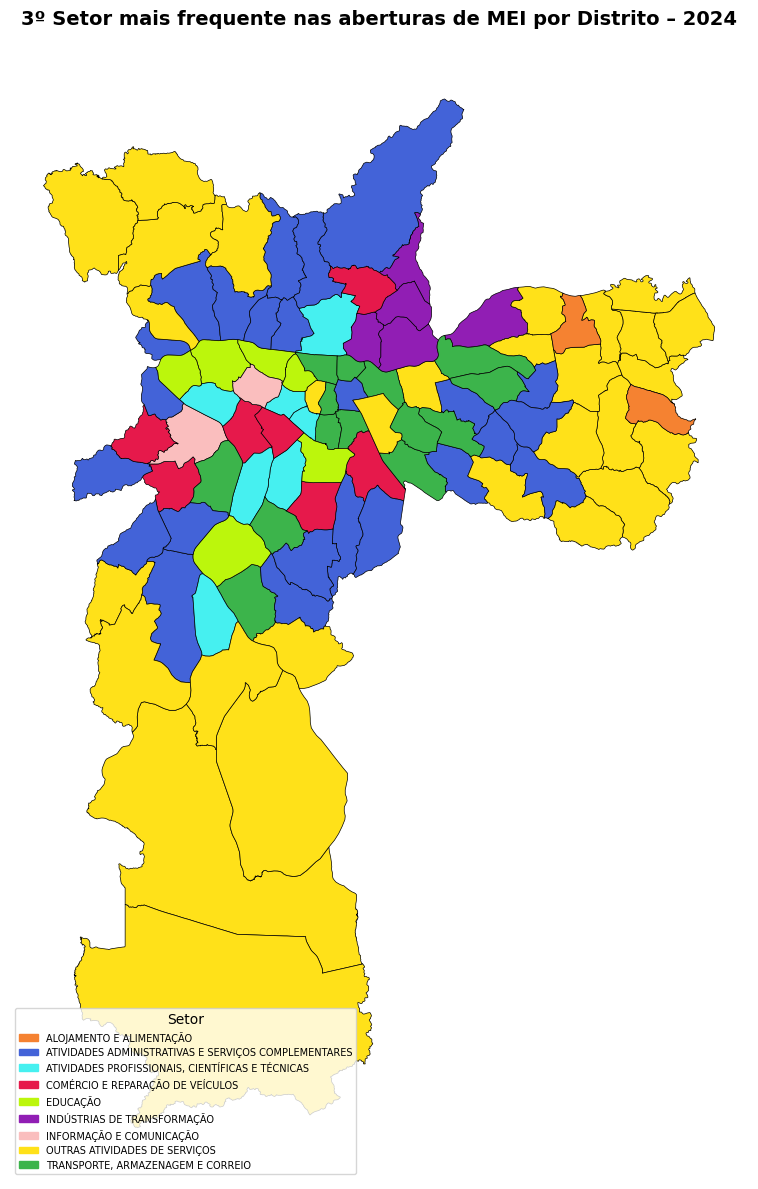

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


# PARÂMETROS

ANO = 2024      # ano de referência
RANK = 3        # 1 = mais frequente, 2 = segundo, etc.


# 1. Criar dicionário GLOBAL de cores por setor (fixo no tempo)

todos_setores = (
    resultado
    .groupby('setor')['qtd_aberturas_mei']
    .sum()
    .sort_values(ascending=False)
    .index
    .tolist()
)

cores_distintas = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
    '#ff6347', '#40e0d0', '#ff1493'
]

if len(todos_setores) > len(cores_distintas):
    np.random.seed(42)
    cores_distintas.extend([
        '#' + ''.join(np.random.choice(list('0123456789ABCDEF'), 6))
        for _ in range(len(todos_setores) - len(cores_distintas))
    ])

setor_colors = {setor: cores_distintas[i] for i, setor in enumerate(todos_setores)}


# 2. Pipeline: Top N setor por distrito no ano escolhido

top_n_por_distrito = (
    resultado
    .query("ano == @ANO")
    .groupby(['cod_distrito', 'Nome_Distrito', 'setor'], as_index=False)
    ['qtd_aberturas_mei']
    .sum()
    .sort_values(['cod_distrito', 'qtd_aberturas_mei'], ascending=[True, False])
    .groupby(['cod_distrito', 'Nome_Distrito'])
    .nth(RANK - 1)
    .reset_index()
)


# 3. Merge com geodataframe + aplicação das cores

gdf_map = (
    gdf
    .merge(
        top_n_por_distrito,
        left_on='nm_distrito_municipal',
        right_on='Nome_Distrito',
        how='left'
    )
    .assign(color=lambda df: df['setor'].map(setor_colors))
)


# 4. Plot do mapa

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

gdf_map.plot(
    ax=ax,
    color=gdf_map['color'],
    edgecolor='black',
    linewidth=0.5
)

ax.set_title(
    f'{RANK}º Setor mais frequente nas aberturas de MEI por Distrito – {ANO}',
    fontsize=14,
    fontweight='bold'
)
ax.axis('off')


# 5. Legenda (somente setores presentes no mapa)

setores_no_mapa = sorted(gdf_map['setor'].dropna().unique())

legend_handles = [
    mpatches.Patch(color=setor_colors[setor], label=setor)
    for setor in setores_no_mapa
]

ax.legend(
    handles=legend_handles,
    title='Setor',
    loc='lower left',
    frameon=True,
    fontsize=7
)

plt.tight_layout()

plt.savefig(
    "setor_freq_3.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True
)

plt.show()